<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=18JwHT8YDIJhm1Of7wvk65XdVfWxcg4af' width="200" />
<figcaption></figcaption></center>
</figure>

# ***Resolución de problemas directos e inversos de ecuaciones diferenciales mediante técnicas de deep learning***

**Practicantes:** Fernando Fêtis y Diego Olguín. 

**Supervisor:** Hugo Carrillo.




In [3]:
from shapely.affinity import affine_transform
from shapely.geometry import Point, Polygon
from shapely.ops import triangulate
from shapely.prepared import prep

import shapely 
import numpy as np

import matplotlib
import matplotlib.pyplot as plt


import random

import torch
import torch.nn as nn

from scipy import stats

from matplotlib.animation import FuncAnimation

In [2]:
#@title Generación de mallas poligonales

class PolygonMesh:

  def __init__(self, vertices):

    P = shapely.Polygon(vertices)

    self.vertices = vertices
    self.geometry = shapely.geometry.polygon.orient(P)
    self.edges = self._get_edges()
    self.normals = {}
    self.samples = {}
    self.interior_subdomains = {}
    self.boundary_subdomains = {}

  def _get_edges(self):
    edges = []
    N_edges = len(self.geometry.boundary.coords)

    for i in range(N_edges-1):
      (x0, y0), (x1, y1) = self.geometry.boundary.coords[i], self.geometry.boundary.coords[i+1]
      edges.append([(x0, y0), (x1, y1)])
    
    return edges

  def add_interior_subdomain(self, subdomain, name=""):
    keys = self.interior_subdomains.keys()
    if name=="":
      name = "int"+str(len(keys)+1)
    elif name=="res":
      name = "int"+str(len(keys)+1)
      print("'res' is not a valid name for subdomain, instead using "+name)

    self.interior_subdomains[name] = subdomain
  

  def add_boundary_subdomain(self, subdomain, name=""):
    keys = self.boundary_subdomains.keys()
    if name=="":
      name = "int"+str(len(keys)+1)
    elif name=="res":
      name = "int"+str(len(keys)+1)
      print("'res' is not a valid name for subdomain, instead using "+name)

    self.boundary_subdomains[name] = subdomain


  def sample_interior(self, k_samples):

    if self.interior_subdomains != {}:
      k = sum(k_samples.values())
      self.samples['interior'] = {}

      i_points = {}

      for key in self.interior_subdomains.keys():
        i_points[key] = []

      i_points['res'] = []

      T = triangulate(self.geometry)
      triangs = [t for t in T if self.geometry.contains(t)]

      areas = []
      transforms = []
      for t in triangs:
          areas.append(t.area)
          (x0, y0), (x1, y1), (x2, y2), _ = t.exterior.coords
          transforms.append([x1 - x0, x2 - x0, y1 - y0, y2 - y0, x0, y0])

      for transform in random.choices(transforms, weights=areas, k=k):
          x, y = np.random.random(2)
          if x + y > 1:
            x, y = 1 - x, 1 - y 
            p = Point(x, y)
          else:
            p = Point(x, y)

          t_point = affine_transform(p, transform)
            
          xn, yn = t_point.coords.xy[0][0], t_point.coords.xy[1][0]
          bound = 'res'

          for key in self.interior_subdomains.keys():
            if self.interior_subdomains[key](xn, yn):
              if len(i_points[key]) < k_samples[key]:
                bound = key
              else:
                bound = ''

            if bound != '':
              i_points[bound].append(t_point)

      for key in self.interior_subdomains.keys():
        points = i_points[key]
        torch_points = torch.tensor([p.coords for p in points]).reshape(-1, 2).T
        self.samples['interior'][key] = torch_points

      torch_points = torch.tensor([p.coords for p in i_points['res']]).reshape(-1, 2).T
      self.samples['interior']['res'] = torch_points

    else:
      k = k_samples

      T = triangulate(self.geometry)
      triangs = [t for t in T if self.geometry.contains(t)]

      areas = []
      transforms = []
      points = []
      for t in triangs:
          areas.append(t.area)
          (x0, y0), (x1, y1), (x2, y2), _ = t.exterior.coords
          transforms.append([x1 - x0, x2 - x0, y1 - y0, y2 - y0, x0, y0])
      
      for transform in random.choices(transforms, weights=areas, k=k):
          x, y = np.random.random(2)
          if x + y > 1:
              p = Point(1 - x, 1 - y)
          else:
              p = Point(x, y)

          points.append(affine_transform(p, transform))

      torch_points = torch.tensor([p.coords for p in points]).reshape(-1, 2).T

      self.samples['interior'] = {'res': torch_points}

    return self.samples['interior']


  def sample_boundary(self, k_samples):

    if self.boundary_subdomains != {}:
      k = sum(k_samples.values())

      b_points, lengths, edges = {}, [], []
      N_edges = len(self.geometry.boundary.coords)

      for key in self.boundary_subdomains.keys():
        b_points[key] = []

      b_points['res'] = []

      for i in range(N_edges-1):
        (x0, y0), (x1, y1) = self.geometry.boundary.coords[i], self.geometry.boundary.coords[i+1]
        lengths.append(np.sqrt((x1-x0)**2 + (y1-y0)**2))
        edges.append([(x0, y0), (x1, y1)])

      for edge in random.choices(edges, weights=lengths, k=k):
        lambd = np.random.random()
        (x0, y0), (x1, y1) = edge
        xn, yn = (1-lambd)*x0 + lambd*x1, (1-lambd)*y0 + lambd*y1

        bound = 'res'

        for key in self.boundary_subdomains.keys():
          if self.boundary_subdomains[key](xn, yn):
            if len(b_points[key]) < k_samples[key]:
              bound = key
            else:
              bound = ''

        if bound != '':
          b_points[bound].append(Point(xn, yn))

      self.samples['boundary'] = {}

      for key in self.boundary_subdomains.keys():

        torch_points = torch.tensor([p.coords for p in b_points[key]]).reshape(-1, 2).T
        self.samples['boundary'][key] = torch_points
        self.normals[key] = self._normal_vector(torch_points[0], torch_points[1])

      torch_points = torch.tensor([p.coords for p in b_points['res']]).reshape(-1, 2).T
      self.samples['boundary']['res'] = torch_points
      self.normals['res'] = self._normal_vector(torch_points[0], torch_points[1])
      
    else:
      k = k_samples 

      b_points, lengths, edges = [], [], []
      N_edges = len(self.geometry.boundary.coords)

      for i in range(N_edges-1):
        (x0, y0), (x1, y1) = self.geometry.boundary.coords[i], self.geometry.boundary.coords[i+1]
        lengths.append(np.sqrt((x1-x0)**2 + (y1-y0)**2))
        edges.append([(x0, y0), (x1, y1)])

      for edge in random.choices(edges, weights=lengths, k=k):
        lambd = np.random.random()
        (x0, y0), (x1, y1) = edge
        b_points.append(Point((1-lambd)*x0 + lambd*x1, (1-lambd)*y0 + lambd*y1))

      torch_points = torch.tensor([p.coords for p in b_points]).reshape(-1, 2).T

      self.samples['boundary'] = {'res': torch_points}

      self.normals['res'] = self._normal_vector(torch_points[0], torch_points[1])

    return self.samples['boundary']


  def plot_samples(self, legend=True):

    if self.samples == {}:
      print("No samples to plot. Generate samples first.")

    else:
      if 'interior' in self.samples.keys():
        for key in self.samples['interior'].keys():
          plt.plot(*self.samples['interior'][key], '.', label=key)

      if 'boundary' in self.samples.keys():
        for key in self.samples['boundary'].keys():
          plt.plot(*self.samples['boundary'][key], '.', label=key)

      if legend:
        plt.legend()  


  def plot(self):
    x = np.array(self.geometry.exterior.coords.xy[0])
    y = np.array(self.geometry.exterior.coords.xy[1])

    plt.fill(x,y, facecolor='lightblue', edgecolor='blue')
    plt.show()


  def _normal_vector(self, x, y, tol=1e-3):
    E = self.edges
    N = len(E)

    normals = torch.zeros((len(x), 2))

    for i in range(len(x)):

      con_edge = torch.zeros(2)
      xi, yi = x[i], y[i]

      for j in range(N):
        edge = shapely.LineString(E[j])
        buf = edge.buffer(tol)
        if buf.contains(Point(xi.item(), yi.item())):
          con_edge = torch.tensor(E[j][1]) - torch.tensor(E[j][0])

      if torch.dot(con_edge, con_edge)==0:
        print("Point not in boundary or Point it's a vertex")
        n = torch.zeros(2)

      elif con_edge[0].item() == 0:
        n = torch.tensor([1., 0.])
        n *= torch.sign(n[0]*con_edge[1] - n[1]*con_edge[0])

      else:
        e1 = torch.tensor([0., 1.])
        n = e1 - torch.dot(e1, con_edge)/torch.dot(con_edge, con_edge) * con_edge 
        n *= torch.sign(n[0]*con_edge[1] - n[1]*con_edge[0])/torch.linalg.norm(n)

      normals[i] = n

    return normals.reshape(2, len(x))


  def grid(self, step):

    latmin, lonmin, latmax, lonmax = self.geometry.bounds
    prep_polygon = prep(self.geometry)

    points = []
    for lat in np.arange(latmin, latmax, step):
        for lon in np.arange(lonmin, lonmax, step):
            points.append(Point((round(lat,4), round(lon,4))))

    valid_points = []
    valid_points.extend(filter(prep_polygon.contains, points))

    grid_coords = torch.tensor([p.coords for p in valid_points]).reshape(-1, 2)

    x, y = grid_coords.T

    return x, y

In [10]:
def koch_snowflake(order, scale=10):
    """
    Return two lists x, y of point coordinates of the Koch snowflake.

    Parameters
    ----------
    order : int
        The recursion depth.
    scale : float
        The extent of the snowflake (edge length of the base triangle).
    """
    def _koch_snowflake_complex(order):
        if order == 0:
            # initial triangle
            angles = np.array([0, 120, 240]) + 90
            return scale / np.sqrt(3) * np.exp(np.deg2rad(angles) * 1j)
        else:
            ZR = 0.5 - 0.5j * np.sqrt(3) / 3

            p1 = _koch_snowflake_complex(order - 1)  # start points
            p2 = np.roll(p1, shift=-1)  # end points
            dp = p2 - p1  # connection vectors

            new_points = np.empty(len(p1) * 4, dtype=np.complex128)
            new_points[::4] = p1
            new_points[1::4] = p1 + dp / 3
            new_points[2::4] = p1 + dp * ZR
            new_points[3::4] = p1 + dp / 3 * 2
            return new_points

    points = _koch_snowflake_complex(order)
    x, y = points.real, points.imag
    return x, y

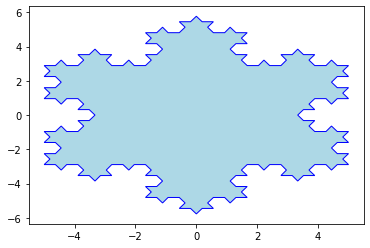

In [11]:
x_koch, y_koch = koch_snowflake(3)
points_koch = torch.tensor([(round(x,2), round(y,2)) for (x,y) in zip(x_koch, y_koch)])
domain = PolygonMesh(points_koch)
domain.plot()

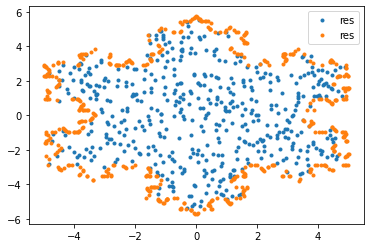

In [13]:
domain.sample_interior(500)
domain.sample_boundary(500)
domain.plot_samples()
plt.show()

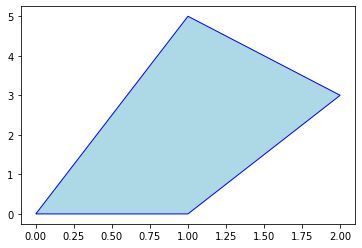

In [14]:
vertices = torch.tensor([(0., 0.), (1., 0.), (2, 3), (1, 5)])
poly = PolygonMesh(vertices)
poly.plot()

In [5]:
def subdomain_int(x,y):
  return x > 1

def subdomain_boun(x,y):
  return x > 1.5

In [6]:
poly.add_interior_subdomain(subdomain_int, 'right_int')
poly.add_boundary_subdomain(subdomain_boun, 'right_boun')

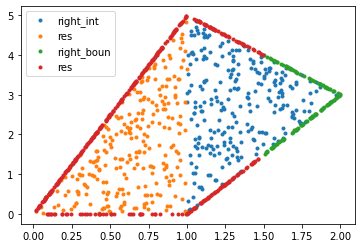

In [8]:
poly.sample_interior({'res': 250, 'right_int': 250})
poly.sample_boundary({'res': 250, 'right_boun': 250})
poly.plot_samples()
plt.show()